# Técnicas avanzadas


En este curso, exploraremos técnicas para mejorar la confiabilidad y facilidad de entrenamiento de las redes neuronales.
Para ilustrar estas técnicas, utilizaremos el conjunto de datos [MNIST](https://es.wikipedia.org/wiki/Base_de_datos_MNIST), que contiene imágenes de dígitos manuscritos del 0 al 9.
El objetivo es que la red tome una imagen como entrada y determine qué dígito representa.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Creación del conjunto de datos


Para empezar, descargamos el conjunto de datos MNIST. La biblioteca *torchvision* permite gestionar imágenes con PyTorch y proporciona herramientas para cargar conjuntos de datos comunes.


In [4]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

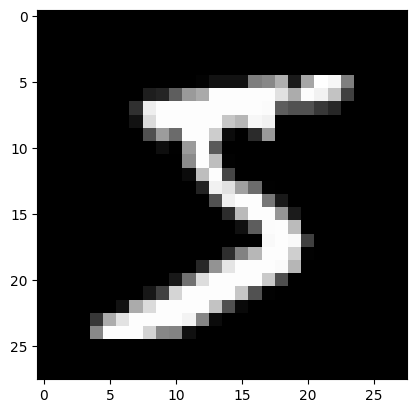

Le chiffre sur l'image est un 5


In [5]:
# On peut visualiser les éléments du dataset
plt.imshow(dataset[0][0].permute(1,2,0).numpy(), cmap='gray')
plt.show()
print("Le chiffre sur l'image est un "+str(dataset[0][1]))

## División en entrenamiento/validación/prueba


Como habrás observado, al cargar el conjunto de datos, contamos con un *train_dataset* y un *test_dataset*. Esta es una práctica esencial para entrenar una red neuronal.
De hecho, una red entrenada con ciertos datos suele tener un buen rendimiento con esos mismos datos. Por lo tanto, es necesario crear un *dataset de prueba* para evaluar el modelo con datos no vistos durante el entrenamiento.

En la práctica, se utilizan 3 subconjuntos:
- El *training split* para entrenar el modelo.
- El *validation split* para evaluar el modelo durante el entrenamiento.
- El *test split* para evaluar el modelo al final del entrenamiento (este es el resultado más importante).

Una práctica común es utilizar una división 60-20-20, es decir, 60% de los datos para entrenamiento, 20% para validación y 20% para prueba. Sin embargo, esta recomendación no es adecuada para todos los conjuntos de datos. Si el conjunto de datos contiene muchas imágenes, se puede reducir la proporción de datos de validación y prueba. Por ejemplo, para conjuntos de datos con miles de millones de imágenes, se suelen utilizar divisiones como 98-1-1 o incluso 99.8-0.1-0.1.


In [6]:
#Le train et test sont déjà séparé, on va donc séparer le train_dataset en train et validation
train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])

# Création des dataloaders pour séparer en mini-batch automatiquement
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Creación y entrenamiento de un primer modelo


Al igual que en el cuaderno anterior, creamos un modelo completamente conectado para el entrenamiento. Dado que los datos de entrada son imágenes de tamaño $28 \times 28$, es necesario convertirlas en un vector 1D de tamaño $28 \times 28 = 784$ para procesarlas en la red.


In [8]:
class mlp(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(784,256) # première couche cachée 
    self.fc2=nn.Linear(256,256) # seconde couche cachée 
    self.fc3=nn.Linear(256,10) # couche de sortie
    
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=x.view(-1,28*28) # Pour convertir l'image de taille 28x28 en tensor de taille 784
    x=F.relu(self.fc1(x)) # le F.relu permet d'appliquer la fonction d'activation ReLU sur la sortie de notre couche 
    x=F.relu(self.fc2(x))
    output=self.fc3(x)
    return output

In [10]:
model = mlp()
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

mlp(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Nombre de paramètres 269322


### Función de pérdida


Para la función de pérdida, utilizamos la *cross entropy loss* de PyTorch, que corresponde a la función de pérdida de la regresión logística para un número de clases mayor que 2.
La función de pérdida se expresa de la siguiente manera:
$\text{Cross Entropy Loss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{ic} \log(p_{ic})$
donde:
- $N$ es el número de ejemplos en el *mini-batch*.
- $C$ es el número de clases.
- $y_{ic}$ es el valor objetivo ($1$ si el ejemplo pertenece a la clase $c$ y $0$ en caso contrario).
- $p_{ic}$ es la predicción de la probabilidad de pertenecer a la clase $c$.


In [11]:
# En pytorch
criterion = nn.CrossEntropyLoss()

### Hiperparámetros y entrenamiento


In [12]:
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

Entrenamiento del modelo (puede tardar unos minutos, dependiendo de la potencia de tu computadora).


In [13]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.29076647758483887
step 0 val loss 0.15385286509990692
step 1 train loss 0.10695428401231766
step 1 val loss 0.10097559541463852
step 2 train loss 0.07086848467588425
step 2 val loss 0.09286081790924072
step 3 train loss 0.05028771981596947
step 3 val loss 0.08867377787828445
step 4 train loss 0.04254501312971115
step 4 val loss 0.0835222601890564


### Verificación del modelo con los datos de prueba


Ahora que el modelo está entrenado, podemos verificar su rendimiento en el *test split*.


In [14]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  97.69


Nuestro modelo obtiene una precisión muy buena en la fase de prueba, lo cual es una buena señal.
Sin embargo, observamos que durante el entrenamiento, la *pérdida de entrenamiento* es menor que la *pérdida de validación*. Este es un punto importante a considerar, ya que indica que el modelo presenta un ligero *overfitting*.


## Overfitting y underfitting


Un elemento clave del aprendizaje profundo es la capacidad del modelo para no presentar *overfitting* con los datos de entrenamiento. El *overfitting* ocurre cuando un modelo aprende demasiado bien los datos de entrenamiento, pero no es capaz de generalizar a nuevos elementos de la misma distribución.
Para comprender el principio, aquí hay una figura que muestra la diferencia entre el *underfitting* (modelo demasiado simple que no puede aprender la complejidad de los datos), un modelo bien entrenado y el *overfitting*.

![Overfitting](./images/overfitting.png)


En el caso más crítico de *overfitting*, el modelo tiene una precisión casi perfecta en los datos de entrenamiento, pero un mal rendimiento en los datos de validación y prueba.
En este curso, introduciremos 2 métodos para evitar este problema de *overfitting*.


### Regularización L2


La regularización L2 es un método que consiste en añadir una penalización a la pérdida basada en el valor de los pesos del modelo. Esta penalización es proporcional al cuadrado de los valores de los pesos del modelo (cabe señalar que también existe la regularización L1, que es linealmente proporcional a los valores de los pesos del modelo). Esta penalización fomenta que los pesos del modelo permanezcan pequeños y sean menos sensibles al ruido de los datos de entrenamiento.
Podemos formular la regularización L2 de la siguiente manera:
$L(w) = L_0(w) + \lambda \sum_{i=1}^{n} w_i^2$
donde:
- $L(w)$ es la pérdida regularizada.
- $L_0(w)$ es la función de pérdida clásica.
- $\lambda$ es el coeficiente de regularización.
- $w_i$ es un peso del modelo.

Para aprender más sobre la regularización L2, puedes consultar el [curso adicional sobre regularización](../Bonus_CoursSpécifiques/06_Regularisation.ipynb) o este [artículo](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c).


Volvamos a entrenar añadiendo la regularización. En PyTorch, la regularización se utiliza añadiendo el parámetro *weight_decay* a nuestro *optimizer*. El valor de *weight_decay* corresponde al $\lambda$ de la ecuación anterior.


In [15]:
model_with_reg=mlp()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model_with_reg.parameters(),lr=learning_rate,weight_decay=1e-5)

for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model_with_reg(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model_with_reg(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.2986273467540741
step 0 val loss 0.1439662128686905
step 1 train loss 0.11165566742420197
step 1 val loss 0.10781095176935196
step 2 train loss 0.07492929697036743
step 2 val loss 0.09555892646312714
step 3 train loss 0.05378309637308121
step 3 val loss 0.08672302216291428
step 4 train loss 0.041800014674663544
step 4 val loss 0.0883878618478775


In [16]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model_with_reg(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  97.73


La diferencia no es muy notable, pero observamos una disminución en la diferencia entre la pérdida de validación y la pérdida de entrenamiento.


**Intuición**: La regularización L2 funciona porque, al penalizar los coeficientes grandes, favorece soluciones en las que los pesos están distribuidos de manera más uniforme. Esto reduce la sensibilidad del modelo a las variaciones específicas de los datos de entrenamiento y mejora así la robustez y la generalización del modelo.


### Dropout


Otra técnica de regularización es el *dropout*. Este método consiste en desactivar aleatoriamente un porcentaje de neuronas en la red en cada paso del entrenamiento (los pesos desactivados cambian durante el entrenamiento). Cada neurona de una capa tiene una probabilidad $p$ de ser desactivada.

Esta técnica obliga a la red a no depender de ciertas neuronas, sino a aprender representaciones más robustas y que generalicen mejor. Podemos ver el *dropout* como una especie de conjunto de modelos donde cada modelo es diferente (porque algunas neuronas están desactivadas). Durante la fase de prueba, se toma el "promedio" de estos diferentes modelos. Durante la fase de prueba, el *dropout* está desactivado.


Para aplicar el *dropout*, es necesario añadirlo directamente en la arquitectura de la red.


In [17]:
class mlp_dropout(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(784,256) 
    self.dropout1 = nn.Dropout(0.2) # on désactive 20% des neurones aléatoirement
    self.fc2=nn.Linear(256,256) 
    self.dropout2 = nn.Dropout(0.2) # on désactive 20% des neurones aléatoirement
    self.fc3=nn.Linear(256,10) 
  
  def forward(self,x):
    x=x.view(-1,28*28)
    x=F.relu(self.dropout1(self.fc1(x)))
    x=F.relu(self.dropout2(self.fc2(x)))
    output=self.fc3(x)
    return output

In [18]:
model_with_dropout=mlp_dropout()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model_with_dropout.parameters(),lr=learning_rate)

for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model_with_dropout(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model_with_dropout(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.3267715573310852
step 0 val loss 0.19353896379470825
step 1 train loss 0.13504144549369812
step 1 val loss 0.14174170792102814
step 2 train loss 0.10012412816286087
step 2 val loss 0.13484247028827667
step 3 train loss 0.07837768644094467
step 3 val loss 0.10895466059446335
step 4 train loss 0.0631122887134552
step 4 val loss 0.10599609464406967


In [25]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model_with_dropout(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  96.96


Observamos nuevamente una ligera mejora en el resultado del entrenamiento.


**Intuición**: El *dropout* mejora la generalización al desactivar aleatoriamente neuronas durante el entrenamiento. Esto evita que el modelo dependa demasiado de ciertas neuronas y fomenta una distribución más robusta y diversificada de las características aprendidas.


## Normalización por lotes (*Batch Normalization*)


Otra técnica para mejorar el entrenamiento de una red neuronal es la *Normalización por lotes* (*Batch Normalization* o *BatchNorm*). El principio consiste en normalizar las entradas de cada capa de la red con una distribución que tenga una media nula y una varianza de 1.
La normalización se realiza en el *batch* completo de la siguiente manera:

Para un *mini-batch* $B$ con activaciones $x$:
- $\mu_B = \frac{1}{m} \sum_{i=1}^m x_i$: la media de las activaciones $x_i$ de los $m$ elementos.
- $\sigma_B^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2$: la varianza de las activaciones $x_i$ de los $m$ elementos.
- $\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$: el valor normalizado de $x_i$.
- $y_i = \gamma \hat{x}_i + \beta$: la adición de los parámetros $\gamma$ y $\beta$ permite a la red aprender las distribuciones de activación óptimas.

donde:
- $m$ es el tamaño del *mini-batch* $B$.
- $\epsilon$ es una pequeña constante añadida para evitar la división por cero.
- $\gamma$ y $\beta$ son parámetros aprendibles.

En la práctica, se constatan 4 ventajas principales al utilizar *BatchNorm*:
- **Aceleración del entrenamiento**: La normalización de las entradas de cada capa permite utilizar una *tasa de aprendizaje* más alta y, por lo tanto, acelerar la convergencia del entrenamiento.
- **Reducción de la sensibilidad a la inicialización de los pesos**: La *BatchNorm* permite estabilizar la distribución de las activaciones, lo que hace que la red sea menos sensible a la inicialización de los pesos.
- **Mejora de la generalización**: Al igual que el *dropout* y la regularización L2, la *BatchNorm* actúa como una forma de regularización. Esto se debe al ruido inducido al normalizar en el *batch*.
- **Reducción del "Internal Covariate Shift"**: La estabilización de las activaciones a lo largo de la red permite reducir el cambio en las distribuciones de las capas internas, lo que facilita el aprendizaje.

Lo que hay que recordar es que la *BatchNorm* ofrece numerosas ventajas y, por lo tanto, se recomienda utilizarla sistemáticamente.

También existen otras técnicas de normalización como *LayerNorm*, *InstanceNorm*, *GroupNorm*, entre otras.
Para aprender más sobre la *normalización por lotes*, puedes realizar el [curso adicional sobre *batch norm*](../Bonus_CoursSpécifiques/02_BatchNorm.ipynb), leer el [artículo](https://arxiv.org/pdf/1502.03167) o este [blogpost](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739).
Para obtener más información sobre la importancia de la normalización en el entrenamiento de redes neuronales, puedes consultar este [blogpost](https://medium.com/nerd-for-tech/overview-of-normalization-techniques-in-deep-learning-e12a79060daf).


En pratique, on constate 4 principaux avantages lors de l'utilisation de la *BatchNorm* :
- **Accélération de l'entraînement** : La normalisation des entrées de chaque couche permet d'utiliser un *learning rate* plus élevé et donc d'accélérer la convergence de l'entraînement.
- **Réduction de la sensibilité à l'initialisation des poids** : La *BatchNorm* permet de stabiliser la distribution des activations, ce qui rend le réseau moins sensible à l'initialisation des poids.
- **Amélioration de la généralisation** : Comme le *dropout* et la régularisation L2, la *BatchNorm* agit comme une forme de régularisation. Cela est dû au bruit induit par le fait de normaliser sur le *batch*.
- **Réduction du "Internal Covariate Shift"** : La stabilisation des activations tout au long du réseau permet de réduire le changement des distributions des couches internes, ce qui facilite l'apprentissage.

Ce qu'il faut retenir, c'est que la *BatchNorm* offre de nombreux avantages et il est donc conseillé de l'utiliser systématiquement.

Il existe également d'autres techniques de normalisation comme la *LayerNorm*, la *InstanceNorm*, la *GroupNorm* et d'autres ...
Pour en apprendre plus sur la *batch normalization*, tu peux faire le [cours bonus sur la *batch norm*](../Bonus_CoursSpécifiques/02_BatchNorm.ipynb), lire le [papier](https://arxiv.org/pdf/1502.03167) ou le [blogpost](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739).
Pour avoir des informations supplémentaires sur l'intérêt de la normalisation pour l'entraînement des réseaux de neurones, tu peux consulter le [blogpost](https://medium.com/nerd-for-tech/overview-of-normalization-techniques-in-deep-learning-e12a79060daf).


Para implementar la *BatchNorm* en PyTorch, es necesario añadirla directamente en la construcción del modelo. Cabe señalar que a menudo se aplica la *BatchNorm* antes de la función de activación, aunque ambas opciones son posibles (antes o después).


In [26]:
class mlp_bn(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(784,256) 
    self.bn1=nn.BatchNorm1d(256) # Batch Normalization
    self.fc2=nn.Linear(256,256) 
    self.bn2=nn.BatchNorm1d(256) # Batch Normalization
    self.fc3=nn.Linear(256,10) 
  
  def forward(self,x):
    x=x.view(-1,28*28)
    x=F.relu(self.bn1(self.fc1(x)))
    x=F.relu(self.bn1(self.fc2(x)))
    output=self.fc3(x)
    return output

In [27]:
model_with_bn=mlp_bn()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model_with_bn.parameters(),lr=learning_rate)

for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model_with_bn(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model_with_bn(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.20796926319599152
step 0 val loss 0.1327729970216751
step 1 train loss 0.09048832952976227
step 1 val loss 0.10177803039550781
step 2 train loss 0.0635765939950943
step 2 val loss 0.09861738979816437
step 3 train loss 0.045849185436964035
step 3 val loss 0.09643400460481644
step 4 train loss 0.0397462323307991
step 4 val loss 0.08524414896965027


In [28]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model_with_bn(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  97.19


Como puedes ver, la *BatchNorm* permite obtener una mejor puntuación en nuestros datos bajo las mismas condiciones de entrenamiento.
